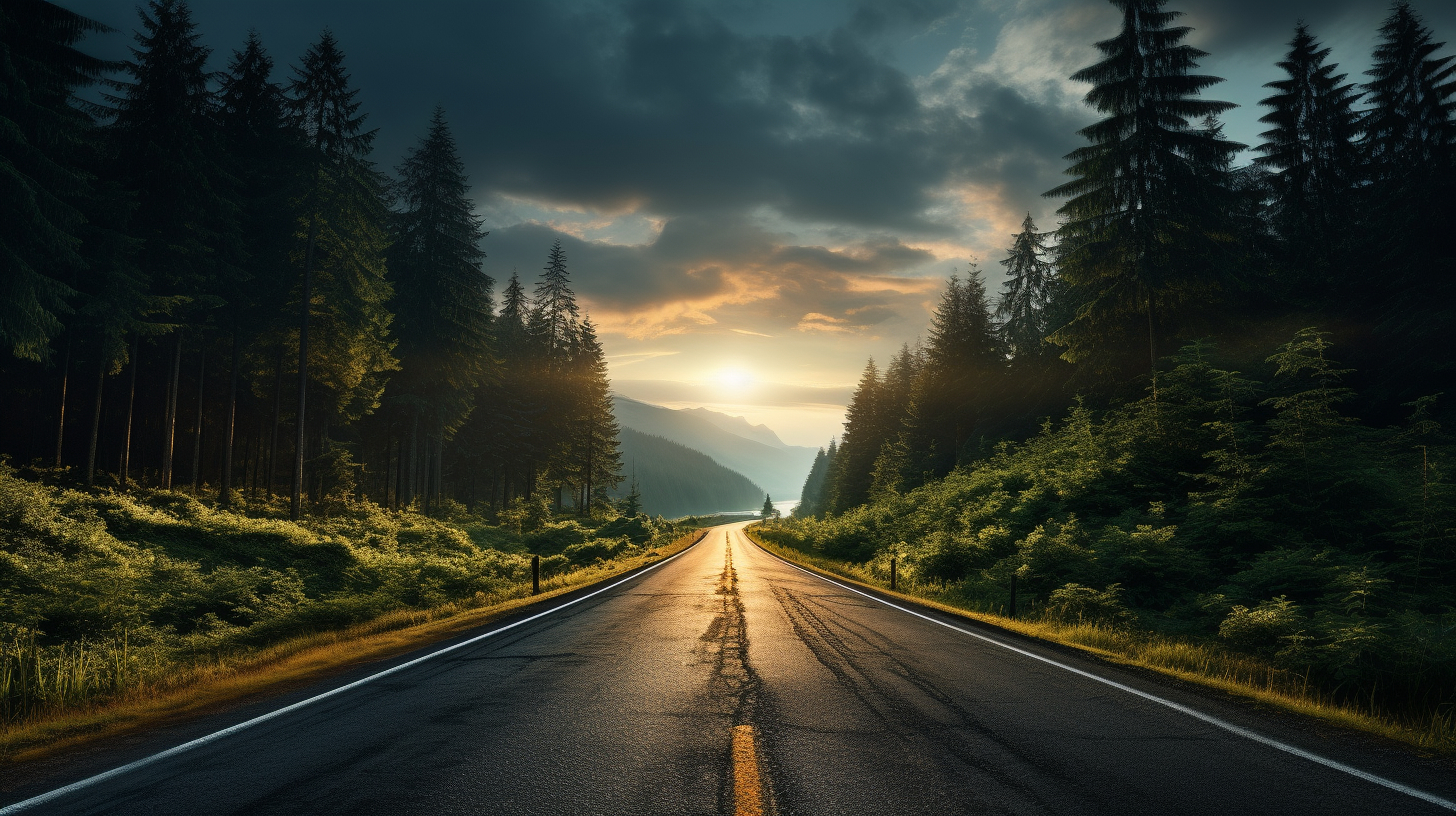

# Distinguishing Urban Roads from Non-Road Regions in the Indian Driving Dataset(IDD) Using Binary Deep Learning Segmentation 🛣️

## Understanding U-Net Architecture

U-Net is a convolutional neural network (CNN) architecture, often considered an enhanced autoencoder, specifically designed for image segmentation tasks, where the goal is to assign a label (e.g., road, building, tree) to each pixel in an image. It extends the traditional autoencoder design by incorporating skip connections between the encoder and decoder layers, enabling the network to preserve spatial details and improve localization. It was first introduced in 2015 for biomedical image segmentation but has since been widely adopted for various segmentation problems due to its efficiency and accuracy.

<table style="width: 100%; border-collapse: collapse; font-family: Arial, sans-serif; line-height: 1.5;">
    <tr>
        <td style="width: 55%; text-align: center; vertical-align: center; border-right: 2px solid #ddd;">
            <img src="https://i.ibb.co/bXXCjRn/U-Net.jpg" alt="U-Net" width="400">
        </td>
        <td style="width: 60%; padding-left: 10px;">
            <div style="text-align: center; margin: 20px 0;">
                <div>Input Image</div>
                <div style="margin: -10px auto; border-left: 2px solid transparent; height: 40px; width: 2px;"></div>
                <div>[Conv + ReLU] → [Conv + ReLU] → [Max Pool] -- Feature Map 1(skip)</div>
                <div style="margin: -10px auto; border-left: 2px solid transparent; height: 40px; width: 2px;"></div>
                <div>[Conv + ReLU] → [Conv + ReLU] → [Max Pool] -- Feature Map 2(skip)</div>
                <div style="margin: -10px auto; border-left: 2px solid transparent; height: 40px; width: 2px;"></div>
                <div>[Conv + ReLU] → [Conv + ReLU] → [Max Pool] -- Feature Map 3(skip)</div>
                <div style="margin: -10px auto; border-left: 2px solid transparent; height: 40px; width: 2px;"></div>
                <div>Bottleneck</div>
                <div style="margin: -10px auto; border-left: 2px solid transparent; height: 40px; width: 2px;"></div>
                <div>[Up-Conv] → [Concat with Feature Map 3] → [Conv + ReLU] → [Conv + ReLU]</div>
                <div style="margin: -10px auto; border-left: 2px solid transparent; height: 40px; width: 2px;"></div>
                <div>[Up-Conv] → [Concat with Feature Map 2] → [Conv + ReLU] → [Conv + ReLU]</div>
                <div style="margin: -10px auto; border-left: 2px solid transparent; height: 40px; width: 2px;"></div>
                <div>[Up-Conv] → [Concat with Feature Map 1] → [Conv + ReLU] → [Conv + ReLU]</div>
                <div style="margin: -10px auto; border-left: 2px solid transparent; height: 40px; width: 2px;"></div>
                <div>Final 1x1 Convolution</div>
                <div style="margin-top: 10px;">Output Segmentation Map</div>
            </div>
        </td>
    </tr>
</table>

U-Net consists of two main components: **the Encoder (Contracting Path)** and **the Decoder (Expansive Path)**. These components are connected through **skip connections**, enabling the network to combine both global context and fine-grained spatial details for accurate image segmentation.

1. **Encoder (Contracting Path)**:
    - The encoder extracts features from the input image while progressively reducing its spatial dimensions. Each step consists of:
        - Two **3x3 convolutional layers** with ReLU activation. `[Conv + ReLU] → [Conv + ReLU]`
        - A **2x2 max pooling layer** for downsampling.          `[Max Pool]`

2. **Decoder (Expansive Path)**:
    - The decoder reconstructs the image back to its original resolution. Each step consists of:
        - **Transposed convolution (up-convolution)** for upsampling. `[Up-Conv]`
        - Concatenation of encoder features via **skip connections**. `[Concat with Feature Map 3]`
        - Two **3x3 convolutional layers** with ReLU activation.      `[Conv + ReLU] → [Conv + ReLU]`

3. **Skip Connections**:
    - Skip connections link encoder feature maps directly to corresponding decoder layers.
    - They preserve spatial information lost during downsampling in the encoder.

4. **Output Layer**:
    - A **1x1 convolutional layer** reduces the feature channels to match the number of segmentation classes.
    - Produces a pixel-wise segmentation map.

## 1. Prepare the Environment and Import Required Libraries

In [1]:
# Optionally for clearing the gpu vram
import torch

# Clear unused memory
torch.cuda.empty_cache()

# Reset the memory allocator
torch.cuda.ipc_collect()

In [2]:
!nvidia-smi

In [3]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from typing import List
import albumentations as A
import torch.optim as optim
from torchmetrics import Dice
from torch.optim import RAdam
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, Subset
from albumentations.pytorch import ToTensorV2
from torchmetrics.segmentation import MeanIoU
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms.functional import to_tensor
from segmentation_models_pytorch.losses import DiceLoss
from torch.utils.data import Dataset, random_split, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, RandomBrightnessContrast, Compose

## 2. Verify that each mask is properly formatted and contains expected values (e.g., binary data for segmentation).

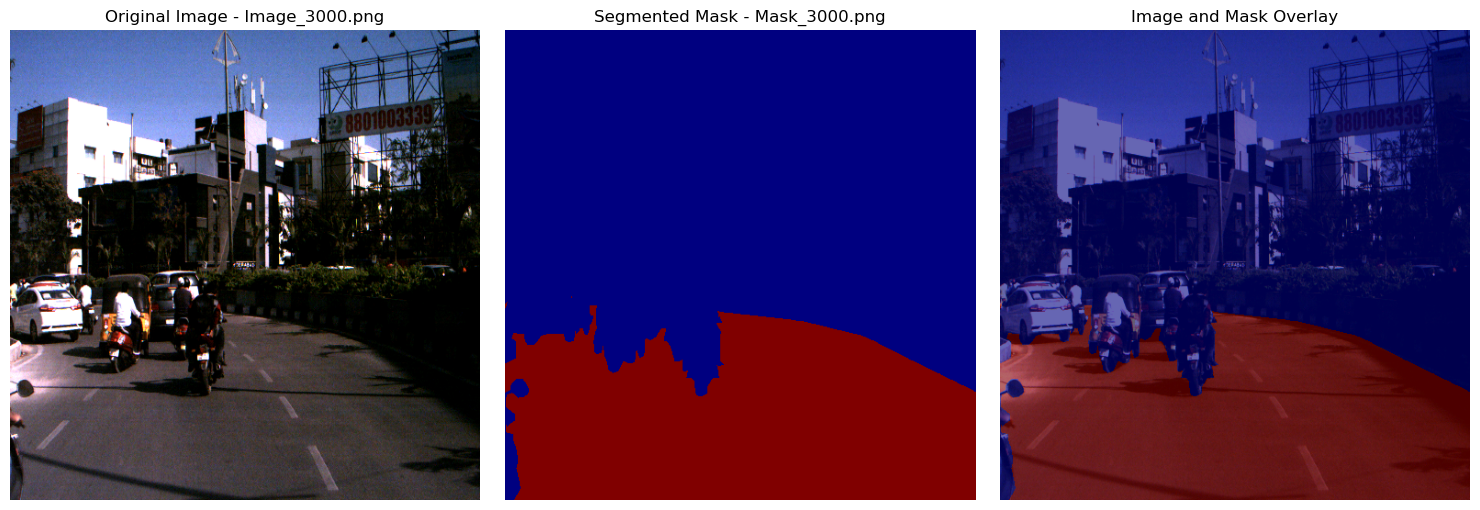

In [4]:
# Define directories for images and masks
image_folder = r'<path_to_your_image_folder>'
mask_folder = r'<path_to_your_mask_folder>'

# Retrieve lists of image and mask file names where each image has a 
# corresponding mask file named similarly (e.g., Image_0.png corresponds to Mask_0.png).
image_files = sorted(os.listdir(image_folder))  
mask_files = sorted(os.listdir(mask_folder))   

# Load the first image
image = cv2.imread(os.path.join(image_folder, image_files[0]), cv2.IMREAD_COLOR) 
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load its corresponding mask
mask = cv2.imread(os.path.join(mask_folder, mask_files[0]), cv2.IMREAD_GRAYSCALE)

# Normalize the mask to span the full range of values
mask_normalized = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Apply a color map to the mask for better visualization
mask_colored = cv2.applyColorMap(mask_normalized, cv2.COLORMAP_JET)
mask_colored_rgb = cv2.cvtColor(mask_colored, cv2.COLOR_BGR2RGB)

# Overlay the mask onto the image
alpha = 0.6
overlay = cv2.addWeighted(image_rgb, 1 - alpha, mask_colored_rgb, alpha, 0)

# Display the image and masks side by side
plt.figure(figsize=(15, 5)) 

# Display original image
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original Image - Image_3000.png")
plt.axis('off')

# Display the colored mask
plt.subplot(1, 3, 2)
plt.imshow(mask_colored_rgb)
plt.title("Segmented Mask - Mask_3000.png")
plt.axis('off')

# Display the overlay
plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Image and Mask Overlay")
plt.axis('off')

plt.tight_layout()  
plt.show()

In [5]:
# Check unique pixel values in the mask
unique_values = np.unique(mask)
print("Unique values in the mask:", unique_values)

Unique values in the mask: [0 1]


## 3. Load and Normalize Data, Apply Augmentations, Split into Training, Validation, and Testing Sets, and Prepare for Model Training.

In [6]:
# Load the dataset
# Optionally you can import different number of images regarding your resources
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, num_images=4000):
        """
        Args:
            image_dir (str): Path to the image folder.
            mask_dir (str): Path to the mask folder.
            transform (callable, optional): Optional transform to apply on images and masks.
            num_images (int, optional): Maximum number of images and masks to include in the dataset.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform  
        self.num_images = num_images

        # Load and sort file lists
        all_image_list = sorted(os.listdir(image_dir))
        all_mask_list = sorted(os.listdir(mask_dir))

        # Assert to ensure there's no mismatch between image and mask counts
        assert len(all_image_list) == len(all_mask_list), "Mismatch between images and masks"

        # Limit the list size to num_images if the total count exceeds num_images
        self.image_list = all_image_list[:min(num_images, len(all_image_list))]
        self.mask_list = all_mask_list[:min(num_images, len(all_mask_list))]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        image = cv2.imread(img_path)  # BGR image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Load mask
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert to PyTorch tensors
        image = to_tensor(image)  
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
            
        return image, mask

In [7]:
# Define augmentations using albumentations
train_augmentations = A.Compose([
    A.HorizontalFlip(p=0.4),
    A.VerticalFlip(p=0.4),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.3),
])

In [8]:
# Initialize full dataset
full_dataset = RoadSegmentationDataset(image_folder, mask_folder, transform=None, num_images=6993)

# Split dataset
train_size = int(0.75 * len(full_dataset))  # 75% training
val_size = int(0.1 * len(full_dataset))  # 10% validation
test_size = len(full_dataset) - train_size - val_size  # 15% testing

train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(full_dataset)),
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Assign appropriate transforms directly to subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

In [9]:
# Create train,val and test datasets with appropriate transforms and indices
train_dataset = RoadSegmentationDataset(image_folder, mask_folder, transform=train_augmentations, num_images=6993)
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)

val_dataset = RoadSegmentationDataset(image_folder, mask_folder, transform=None, num_images=6993)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

test_dataset = RoadSegmentationDataset(image_folder, mask_folder, transform=None, num_images=6993)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)  

# DataLoader for batching
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify splits
print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Verify image and mask shapes
image, mask = full_dataset[0]
print(f"Image Shape: {image.shape}, Pixel Range: {image.min().item()} to {image.max().item()}")
print(f"Mask Shape: {mask.shape}, Pixel Range: {mask.min().item()} to {mask.max().item()}")

Training Dataset Size: 5244
Validation Dataset Size: 699
Test Dataset Size: 1050
Image Shape: torch.Size([3, 512, 512]), Pixel Range: 0.0 to 1.0
Mask Shape: torch.Size([1, 512, 512]), Pixel Range: 0.0 to 1.0


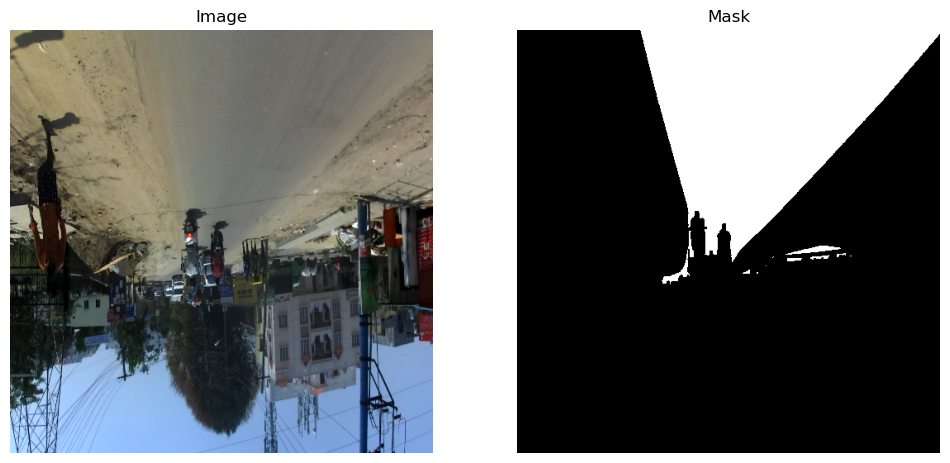

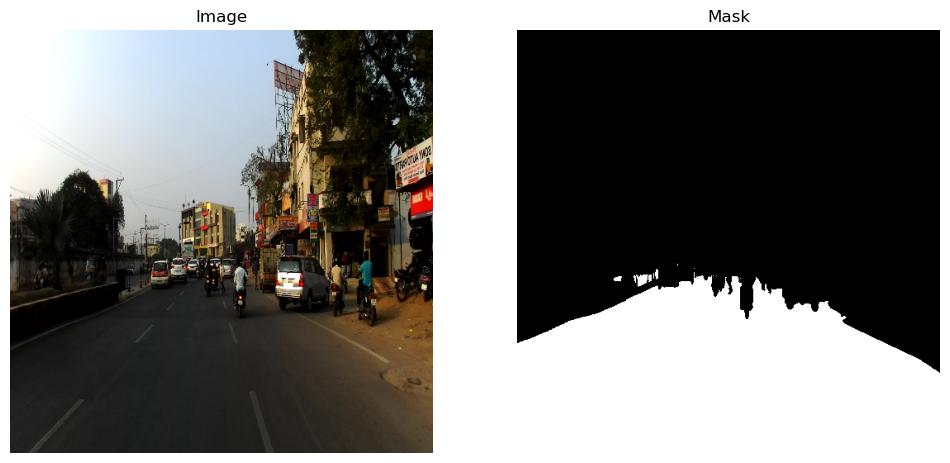

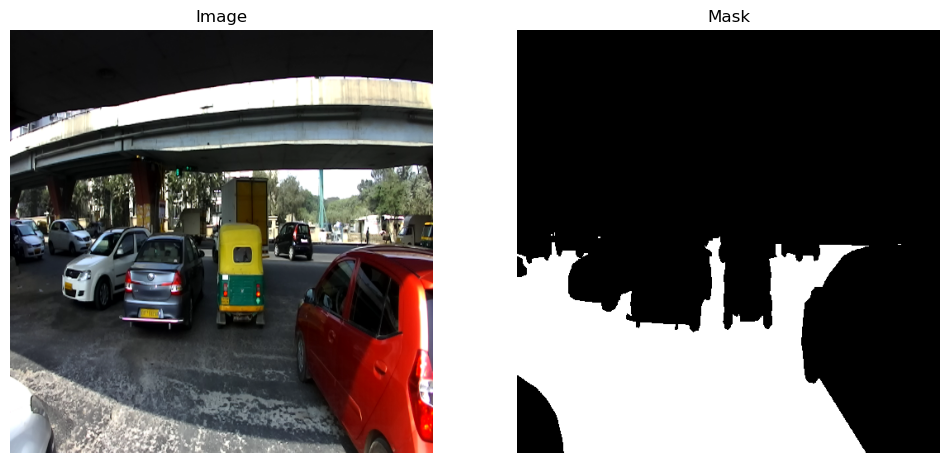

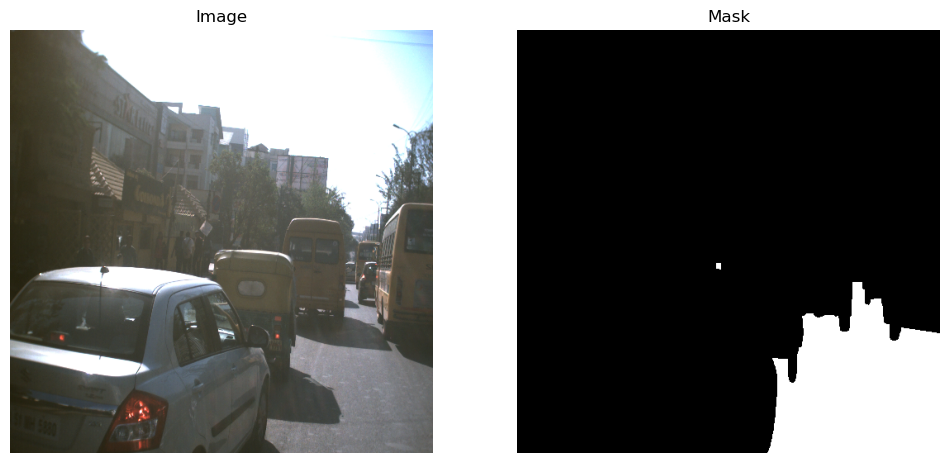

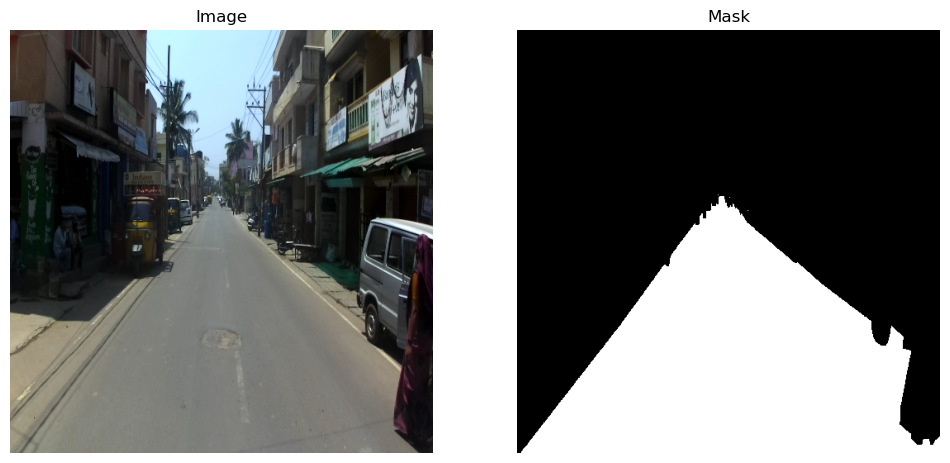

In [10]:
# Function to visualize a training image and its corresponding mask after applying augmentations
def visualize_sample(image, mask):
    # Convert the image tensor (CxHxW) to a numpy array (HxWxC) for display
    image = image.permute(1, 2, 0).cpu().numpy() 
    # Remove the channel dimension from the mask tensor (1xHxW) and convert to a numpy array (HxW)
    mask = mask.squeeze(0).cpu().numpy()  

    # Plot the image and mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')
    
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Mask")
    axes[1].axis('off')
    
    plt.show()

# Visualize random samples from the training dataset to confirm augmentations are applied correctly
for i in range(5):
    idx = random.randint(0, len(train_dataset) - 1)  # Random index
    image, mask = train_dataset[idx]  # Get a random sample
    visualize_sample(image, mask)  

## 4. Model Development

### 4.1 Building U-Net from Scratch

In [ ]:
# Double convolution block with ReLU
class DoubleConvBlock(nn.Module):
    """
    A convolutional block in the UNet architecture that consists of two convolutional layers with batch
    normalization followed by a ReLU activation function.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, padding: int = 1):
        """
        Initializes DoubleConvBlock with specified input and output channels,
        kernel size, and padding.
        """
        super(DoubleConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        # First convolution, batch normalization, and ReLU
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        # Second convolution, batch normalization, and ReLU
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        return x

#### 4.1.1 Encoder Component of the UNet

In [ ]:
class Encoder(nn.Module):
    """
    This class represents the encoder part of the UNet architecture, which systematically applies
    a series of convolutional blocks, each followed by a max pooling operation. These operations
    reduce the spatial dimensions of the feature maps, except after the last convolutional block
    where no pooling occurs to maintain the feature map size for subsequent layers.
    """

    def __init__(self, channels: List[int]):
        """
        Initializes the Encoder module with a sequence of convolutional and max pooling layers.

        Parameters:
            channels (List[int]): A list detailing the number of input and output channels for each
                                  convolutional block. This list determines how many DoubleConvBlock
                                  and MaxPool2d layers are created and their configuration. For example, 
                                  if channels = [3, 64, 128, 256, 512, 1024], the input has 3 channels,
                                  and each subsequent DoubleConvBlock increases the number of features 
                                  to 64, 128, 256, 512, and finally 1024.
        """
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()  

        # Construct each convolutional block and max pooling layer
        for i in range(len(channels) - 1):
            # Add a DoubleConvBlock for each pair of channels
            self.layers.append(DoubleConvBlock(channels[i], channels[i + 1]))

            # Except for the last convolutional block, add a max pooling layer to reduce spatial dimensions
            if i < len(channels) - 2:
                self.layers.append(nn.MaxPool2d(kernel_size=2))

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        features = []
        for layer in self.layers:
            x = layer(x)  # Apply the current layer to the input tensor.
            if isinstance(layer, DoubleConvBlock):
                features.append(x)  # Collect output from each convolutional block for skip connections.
        return features

        return features  # Return the list of features from all the convolution blocks

#### 4.1.2 Decoder Component of the UNet with Skip Connections

In [ ]:
class Decoder(nn.Module):
    """
    This class represents the decoder part of the UNet architecture, designed to progressively 
    reconstruct the image or feature map resolution from the encoded features. It alternates 
    between transposed convolutions (upconvolutions) to upsample the feature maps and 
    convolutional blocks to refine the features after each upsampling.
    """

    def __init__(self, channels: List[int]):
        """
        Initializes the Decoder module with a series of upconvolutions and convolutional blocks.

        Parameters:
            channels (List[int]): A list detailing the output channels for each upconvolution and 
                                  input channels for each convolutional block in the decoder. For 
                                  example, if channels = [1024, 512, 256, 128, 64], each entry 
                                  represents the feature map sizes as the data flows through the decoder.
        """
        super(Decoder, self).__init__()
        self.decoder_blocks = nn.ModuleList()

        # Each step in the decoder consists of:
        #  1. A transpose convolution (up-conv)
        #  2. A double convolution block that operates on the concatenation of 
        #    the upsampled feature map and the corresponding encoder feature map.
        for i in range(len(channels)-1):
            self.decoder_blocks.append(nn.ConvTranspose2d(channels[i], channels[i+1], kernel_size=2, stride=2))
            self.decoder_blocks.append(DoubleConvBlock(channels[i+1]*2, channels[i+1]))


    def _center_crop(self, feature: torch.Tensor, target_size: torch.Tensor) -> torch.Tensor:
        """
        Crops the encoder's feature map tensor to to match the size of the decoder’s feature map for concatenation. 
        This is necessary to ensure that the feature dimensions match between the encoder outputs and the upscaled 
        decoder outputs.

        Parameters:
            feature (torch.Tensor): The feature to be cropped.
            target_size (torch.Tensor): The target tensor size to which the feature should be cropped.

        Returns:
            torch.Tensor: The cropped feature tensor.
        """
        _, _, H, W = target_size.size()
        _, _, h, w = feature.size()

        # Calculate the starting indices for the crop
        h_start = (h - H) // 2
        w_start = (w - W) // 2

        # Crop and returns the tensor
        return feature[:, :, h_start:h_start+H, w_start:w_start+W]

    def forward(self, x: torch.Tensor, encoder_features: List[torch.Tensor]) -> torch.Tensor:
        """
        Parameters:
            x (torch.Tensor): The input tensor to the decoder.
            encoder_features (List[torch.Tensor]): The list of encoder outputs used for skip connections.
    
        Returns:
            torch.Tensor: The output tensor from the decoder after all layers and concatenations.
        """
        # Index to track the corresponding encoder feature
        feature_index = len(encoder_features) - 1
    
        for i in range(0, len(self.decoder_blocks), 2):
            # Up-convolution
            x = self.decoder_blocks[i](x)

            # Concatenate the corresponding encoder feature map before the double conv
            encoder_feature = self._center_crop(encoder_features[feature_index], x)
            x = torch.cat([x, encoder_feature], dim=1)
            feature_index -= 1

            # Double convolution block
            x = self.decoder_blocks[i+1](x)
    
        return x

#### 4.1.3 Final UNet Architecture

In [ ]:
class UNet(nn.Module):
    """
    Initializes the UNet model with an encoder, a decoder, and a final convolution layer
    that maps to the desired number of output channels.

    Attributes:
        out_channels (int): The number of output channels in the final convolution layer.
        channels (List[int]): A sequential list of channel dimensions that defines the complexity
                              and depth of the convolutional blocks within the network.
    """

    def __init__(self, channels: List[int], out_channels: int):
        """
        Parameters:
            channels (List[int]): A list indicating the number of channels for each convolutional
                                  block in the encoder and subsequently the decoder.
            out_channels (int): The number of channels for the output image, which depends on
                                the specific application (e.g., 1 for binary segmentation masks).
        """
        super(UNet, self).__init__()
        self.encoder = Encoder(channels)
        # Initialize the decoder by reversing the channel list (excluding the first entry), 
        # so the structure mirrors the encoder's hierarchy. This ensures the decoder begins 
        # with the second highest number of channels to align with the encoder's output.
        self.decoder = Decoder(channels[1:][::-1])
        # Define the final convolutional layer to map the decoder's output to the desired number of segmentation classes
        self.final_conv = nn.Conv2d(channels[1], out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters:
            x (torch.Tensor): The input image tensor.

        Returns:
            torch.Tensor: The output tensor after processing through the UNet architecture.
        """
        encoder_features = self.encoder(x)
        x = self.decoder(encoder_features[-1], encoder_features[:-1])
        #  Reduces the number of channels to match the number of segmentation classes (segmentation map)
        x = self.final_conv(x)
        return x

In [ ]:
# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Test the unet model with a sample input tensor
model = UNet(channels=[3, 64, 128, 256, 512, 1024], out_channels=1)
x = torch.randn(1, 3, 512, 512)

# Pass the model and the input tensor to device
model = model.to(device)
x = x.to(device)

output = model(x)
print(output.shape)  # The output should be a tensor with shape [1, 1, 512, 512]

### 4.2 Using a Pretrained U-Net

In [11]:
# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize a UNet model with EfficientNet-b3 as the encoder backbone.
# The encoder is pretrained on ImageNet for transfer learning.
# The model is configured to take 3-channel input images and output a single-channel segmentation map (classes=1).
unet_model = smp.Unet(encoder_name="efficientnet-b3", encoder_weights="imagenet", in_channels=3, classes=1)

# Move the UNet model to the gpu
unet_model = unet_model.to(device)

# Specify the path to save the UNetmodel
unet_checkpoint_path=r'<path_to_save_unet_model>'

You can optionally experiment with using an FPN (Feature Pyramid Network) model.

In [12]:
# Test the pretrained model with a sample input tensor
x = torch.randn(1, 3, 512, 512)
x = x.to(device)

output = unet_model(x)
print(output.shape)  # The output should be a tensor with shape [1, 1, 512, 512]

torch.Size([1, 1, 512, 512])


In [ ]:
# Initialize an FPN model with EfficientNet-b3 as the encoder backbone.
# The encoder is pretrained on ImageNet for transfer learning.
# The model is configured to take 3-channel input images and output a single-channel segmentation map (classes=1).
# fpn_model = smp.FPN(encoder_name="efficientnet-b3", encoder_weights="imagenet", in_channels=3, classes=1)

# Move the FPN model to the specified device (e.g., GPU or CPU).
# fpn_model = fpn_model.to(device)

# Specify the path to save the FPN model.
# fpn_checkpoint_path = r'<path_to_save_fpn_model>'

## 5. Model Training 

The output of the model is a single-channel feature map, where each pixel is classified as either foreground (road) or background (non-road). This corresponds to a binary classification problem, where each pixel belongs to one of two categories: road (class 1) or non-road (class 0).

For binary classification tasks in segmentation, Binary Cross-Entropy (BCE) is a standard choice because it evaluates the error between the predicted probabilities and the actual binary labels for each pixel. However, relying solely on BCE can lead to suboptimal results, particularly when the dataset is imbalanced (e.g., roads occupy a smaller area of the image compared to the background). To address this, BCEWithLogitsLoss and Dice Loss will be combined.

#### Binary Cross-Entropy with Logits (BCEWithLogitsLoss):
- Combines the **sigmoid activation function** with binary cross-entropy in a **numerically stable** way.
- Allows the model to output raw logits (unbounded values), avoiding the need for explicit sigmoid activation during the forward pass.

#### Dice Loss
- Measures the **overlap** between the predicted and ground truth masks, directly optimizing for **region-level agreement**.
- Particularly effective for handling **imbalanced datasets**, as it focuses on matching the shapes and sizes of the predicted and true regions.

In [13]:
# Loss Functions
criterion_bce = nn.BCEWithLogitsLoss()
criterion_dice = smp.losses.DiceLoss(mode='binary')

# Combination of BCE and Dice Loss
def combined_loss(output, target):
    bce = criterion_bce(output, target)
    dice = criterion_dice(output, target)
    return 0.75 * bce + 0.25 * dice

# Optimizers
optimizer_unet = optim.RAdam(unet_model.parameters(), lr=0.002)
# optimizer_fpn = optim.RAdam(fpn_model.parameters(), lr=0.001)

# Create lists to track training and validation losses
train_losses = []
val_losses = []

In [14]:
def train_model(model, optimizer, train_loader, val_loader, device, num_epochs=30, 
                patience=5, lr_patience=3, checkpoint_path=None):
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=lr_patience)

    best_val_loss = float('inf')  # Track the best validation loss
    early_stop_counter = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch + 1}/{num_epochs}...")
        
        # Training phase
        model.train()
        running_loss = 0.0
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", unit="batch")
        
        for images, masks in train_iterator:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            if outputs.dim() == 3:
                outputs = outputs.unsqueeze(1)
            elif outputs.shape[1] != 1:
                outputs = outputs.squeeze(1)
            
            if outputs.shape != masks.shape:
                raise ValueError(f"Output and mask shapes do not match: {outputs.shape} vs {masks.shape}")
            
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            train_iterator.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)  # Store training loss
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", unit="batch")
        
        with torch.no_grad():
            for images, masks in val_iterator:
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
                if outputs.dim() == 3:
                    outputs = outputs.unsqueeze(1)
                elif outputs.shape[1] != 1:
                    outputs = outputs.squeeze(1)
                
                if outputs.shape != masks.shape:
                    raise ValueError(f"Output and mask shapes do not match: {outputs.shape} vs {masks.shape}")
                
                val_loss = combined_loss(outputs, masks)
                running_val_loss += val_loss.item() * images.size(0)
                val_iterator.set_postfix(val_loss=val_loss.item())

        validation_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(validation_loss)  # Store validation loss
        
        print(f'Epoch {epoch + 1} completed. Training Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')

        # Get learning rate before scheduler step
        old_lr = optimizer.param_groups[0]['lr']

        # Adjust learning rate based on validation loss
        scheduler.step(validation_loss)

        # Get learning rate after scheduler step
        new_lr = optimizer.param_groups[0]['lr']

        # Print only if the learning rate has changed
        if new_lr != old_lr:
            print(f"Learning rate changed from {old_lr:.6f} to {new_lr:.6f}")

        # Save the best model
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            early_stop_counter = 0  # Reset early stopping counter
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model saved with validation loss: {best_val_loss:.4f}")
        else:
            early_stop_counter += 1
            print(f"Validation loss did not improve. Early stop counter: {early_stop_counter}/{patience}")

        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

In [15]:
# Train the Unet Model
train_model(
    model=unet_model,
    optimizer=optimizer_unet,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=50,
    patience=6,
    lr_patience=2,
    checkpoint_path=unet_checkpoint_path
)

Starting epoch 1/50...


Epoch 1/50 [Val]: 100%|██████████| 88/88 [00:12<00:00,  7.19batch/s, val_loss=0.122] 


Epoch 1 completed. Training Loss: 0.1646, Validation Loss: 0.0861
Best model saved with validation loss: 0.0861
Starting epoch 2/50...


Epoch 2/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.45batch/s, val_loss=0.0968]


Epoch 2 completed. Training Loss: 0.0919, Validation Loss: 0.0843
Best model saved with validation loss: 0.0843
Starting epoch 3/50...


Epoch 3/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.55batch/s, val_loss=0.0749]


Epoch 3 completed. Training Loss: 0.0801, Validation Loss: 0.0842
Best model saved with validation loss: 0.0842
Starting epoch 4/50...


Epoch 4/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.51batch/s, val_loss=0.136] 


Epoch 4 completed. Training Loss: 0.0782, Validation Loss: 0.1443
Validation loss did not improve. Early stop counter: 1/6
Starting epoch 5/50...


Epoch 5/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.54batch/s, val_loss=0.335]


Epoch 5 completed. Training Loss: 0.0784, Validation Loss: 0.3059
Validation loss did not improve. Early stop counter: 2/6
Starting epoch 6/50...


Epoch 6/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.54batch/s, val_loss=0.0844]


Epoch 6 completed. Training Loss: 0.0753, Validation Loss: 0.0736
Best model saved with validation loss: 0.0736
Starting epoch 7/50...


Epoch 7/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.51batch/s, val_loss=0.0814]


Epoch 7 completed. Training Loss: 0.0685, Validation Loss: 0.0735
Best model saved with validation loss: 0.0735
Starting epoch 8/50...


Epoch 8/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.42batch/s, val_loss=0.0999]


Epoch 8 completed. Training Loss: 0.0679, Validation Loss: 0.0801
Validation loss did not improve. Early stop counter: 1/6
Starting epoch 9/50...


Epoch 9/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.52batch/s, val_loss=0.083] 


Epoch 9 completed. Training Loss: 0.0678, Validation Loss: 0.0759
Validation loss did not improve. Early stop counter: 2/6
Starting epoch 10/50...


Epoch 10/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.46batch/s, val_loss=0.0965]


Epoch 10 completed. Training Loss: 0.0660, Validation Loss: 0.0771
Learning rate changed from 0.002000 to 0.000200
Validation loss did not improve. Early stop counter: 3/6
Starting epoch 11/50...


Epoch 11/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.56batch/s, val_loss=0.0854]


Epoch 11 completed. Training Loss: 0.0558, Validation Loss: 0.0583
Best model saved with validation loss: 0.0583
Starting epoch 12/50...


Epoch 12/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.36batch/s, val_loss=0.0831]


Epoch 12 completed. Training Loss: 0.0508, Validation Loss: 0.0572
Best model saved with validation loss: 0.0572
Starting epoch 13/50...


Epoch 13/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.50batch/s, val_loss=0.0799]


Epoch 13 completed. Training Loss: 0.0487, Validation Loss: 0.0568
Best model saved with validation loss: 0.0568
Starting epoch 14/50...


Epoch 14/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.45batch/s, val_loss=0.0823]


Epoch 14 completed. Training Loss: 0.0478, Validation Loss: 0.0557
Best model saved with validation loss: 0.0557
Starting epoch 15/50...


Epoch 15/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.50batch/s, val_loss=0.079] 


Epoch 15 completed. Training Loss: 0.0468, Validation Loss: 0.0562
Validation loss did not improve. Early stop counter: 1/6
Starting epoch 16/50...


Epoch 16/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.45batch/s, val_loss=0.0794]


Epoch 16 completed. Training Loss: 0.0458, Validation Loss: 0.0560
Validation loss did not improve. Early stop counter: 2/6
Starting epoch 17/50...


Epoch 17/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.55batch/s, val_loss=0.0793]


Epoch 17 completed. Training Loss: 0.0447, Validation Loss: 0.0561
Learning rate changed from 0.000200 to 0.000020
Validation loss did not improve. Early stop counter: 3/6
Starting epoch 18/50...


Epoch 18/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.42batch/s, val_loss=0.0804]


Epoch 18 completed. Training Loss: 0.0426, Validation Loss: 0.0562
Validation loss did not improve. Early stop counter: 4/6
Starting epoch 19/50...


Epoch 19/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.41batch/s, val_loss=0.0813]


Epoch 19 completed. Training Loss: 0.0419, Validation Loss: 0.0560
Validation loss did not improve. Early stop counter: 5/6
Starting epoch 20/50...


Epoch 20/50 [Val]: 100%|██████████| 88/88 [00:07<00:00, 11.45batch/s, val_loss=0.0812]

Epoch 20 completed. Training Loss: 0.0422, Validation Loss: 0.0561
Learning rate changed from 0.000020 to 0.000002
Validation loss did not improve. Early stop counter: 6/6
Early stopping triggered after 20 epochs.


In [ ]:
# Train the FPN model
# train_model(
#    model=fpn_model,
#    optimizer=optimizer_fpn,
#    train_loader=train_loader,
#    val_loader=val_loader,
#    device=device,
#    num_epochs=20,
#    patience=5,
#    lr_patience=3,
#    checkpoint_path=fpn_checkpoint_path
#)

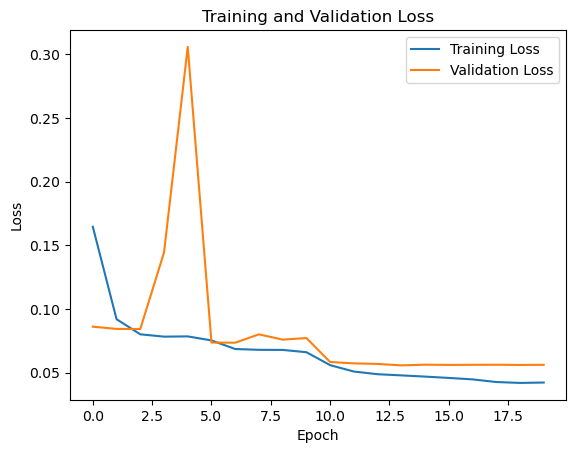

In [16]:
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## 6. Load the Trained Model, Test It, and Display Results

In [17]:
# Load the unet_model
unet_model.load_state_dict(torch.load(unet_checkpoint_path, map_location=device, weights_only=True))

<All keys matched successfully>

In [18]:
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode

    # Initialize metrics
    dice_metric = Dice(average='macro', num_classes=2).to(device)
    iou_metric = MeanIoU(num_classes=2).to(device)

    # No gradient needed for testing
    with torch.no_grad():
        test_iterator = tqdm(test_loader, desc="Testing", unit="batch")
        for images, masks in test_iterator:
            images, masks = images.to(device), masks.to(device)

            # Ensure the target masks are integer tensors
            masks = masks.to(torch.int)
            
            # Get model predictions
            outputs = model(images)
            outputs = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold to get binary masks

            if outputs.shape != masks.shape:
                raise ValueError(f"Output and mask shapes do not match: {outputs.shape} vs {masks.shape}")
            
            # Update metrics
            dice_metric.update(outputs, masks)
            iou_metric.update(outputs, masks)
    
    # Compute final metrics
    avg_dice = dice_metric.compute()
    avg_iou = iou_metric.compute()

    # Reset metrics for future use
    dice_metric.reset()
    iou_metric.reset()

    print(f"Average Dice Coefficient: {avg_dice:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")

    return avg_dice, avg_iou

# Evaluate the model
avg_dice, avg_iou = test_model(unet_model, test_loader, device)

Testing: 100%|██████████| 132/132 [00:19<00:00,  6.92batch/s]

Average Dice Coefficient: 0.9730
Average IoU: 0.9016


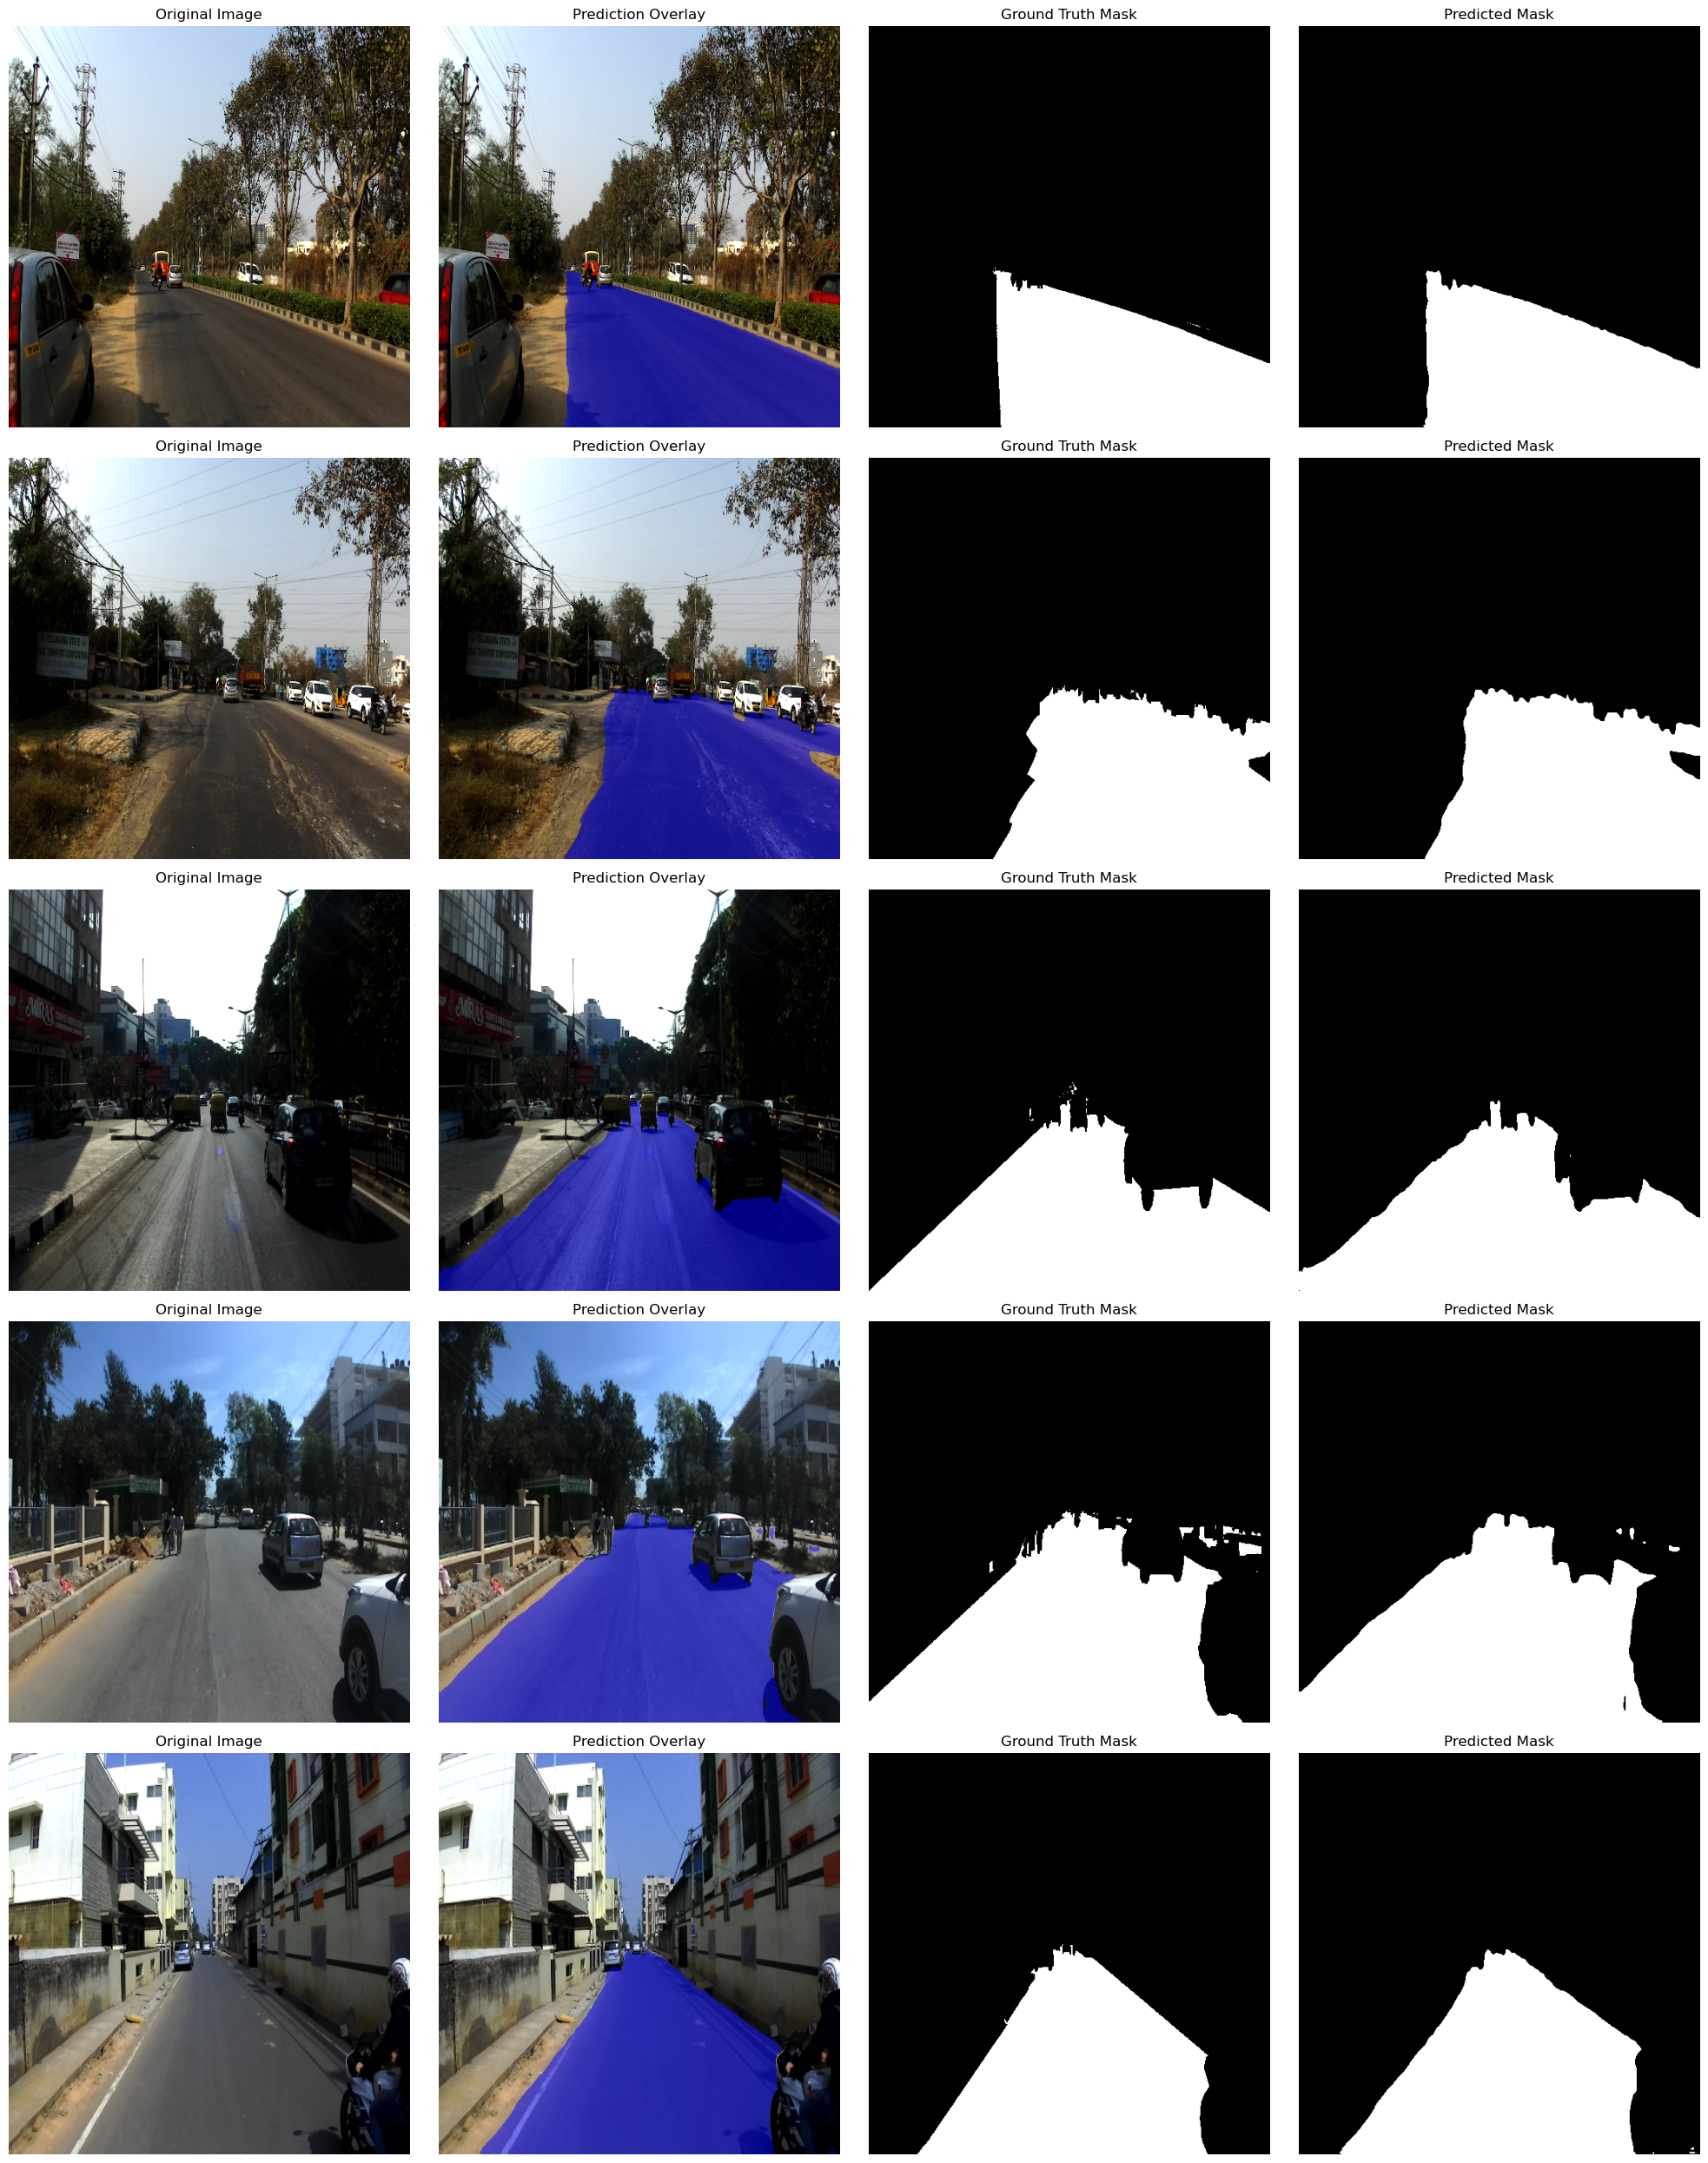

In [19]:
def visualize_segmentation_results(model, test_loader, device, num_images=5):
    model.eval()  # Set the model to evaluation mode

    # Select random samples from the test_loader
    test_samples = random.sample(list(test_loader), num_images)
    
    # Process and visualize each sample
    fig, axes = plt.subplots(num_images, 4, figsize=(20, 5 * num_images))
    for idx, (images, masks) in enumerate(test_samples):
        images, masks = images.to(device), masks.to(device)
        
        # Get model predictions
        with torch.no_grad():
            outputs = model(images)
            outputs = (torch.sigmoid(outputs) > 0.5).float()  # Apply sigmoid and threshold to get binary masks

        # Convert tensors to CPU for visualization
        original_image = images[0].cpu().permute(1, 2, 0).numpy()  # Move channel dimension for RGB images
        original_image = (original_image * 255).astype(np.uint8)  # Scale to [0, 255] for display
        truth_mask = masks[0].squeeze(0).cpu().numpy()  # Squeeze to remove channel dimension
        predicted_mask = outputs[0].squeeze(0).cpu().numpy()  # Squeeze to remove channel dimension

        # Create a copy of the original image for the overlay
        overlay = original_image.copy()
        
        # Normalize the predicted mask for applying the color map
        pred_mask_normalized = cv2.normalize(predicted_mask, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        # Create an empty array with the same shape as the image
        blue_overlay = np.zeros_like(original_image)  
        # Set the blue channel to the normalized mask values
        blue_overlay[:, :, 2] = pred_mask_normalized  
        
        # Blend the original image and the blue overlay
        alpha = 0.5  # Transparency level
        overlay = cv2.addWeighted(original_image, 1 - alpha, blue_overlay, alpha, 0)
        
        # Retain only the predicted regions in the overlay
        overlay[predicted_mask == 0] = original_image[predicted_mask == 0]

        # Plot original image
        axes[idx, 0].imshow(original_image)
        axes[idx, 0].set_title("Original Image")
        axes[idx, 0].axis("off")

        # Plot prediction overlay
        axes[idx, 1].imshow(overlay)
        axes[idx, 1].set_title("Prediction Overlay")
        axes[idx, 1].axis("off")

        # Plot ground truth mask in black and white
        axes[idx, 2].imshow(truth_mask, cmap="gray")
        axes[idx, 2].set_title("Ground Truth Mask")
        axes[idx, 2].axis("off")

        # Plot predicted mask in black and white
        axes[idx, 3].imshow(predicted_mask, cmap="gray")
        axes[idx, 3].set_title("Predicted Mask")
        axes[idx, 3].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the segmentation results
visualize_segmentation_results(unet_model, test_loader, device, num_images=5)